In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astra
import os
from einops import rearrange
from PIL import Image
from numpy.fft import *
astra.test()

ASTRA Toolbox v2.3.1
Getting GPU info... GPU #0: NVIDIA RTX A6000, with 48535MB, CUDA compute capability 8.6
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


In [2]:
path_red_data = "/nas-data/dengyipin/medical_imaging_proj/project1/team12_new1/ScanData"
path_red_ref = "/nas-data/dengyipin/medical_imaging_proj/project1/team12_new1/ScanRef"
img_data = np.ones((480, 800, 640))
for i in range(800):
    filename = f"{i:03d}.bmp"
    with open(os.path.join(path_red_data,filename), 'rb') as f:
        raw_data = np.fromfile(f, dtype=np.uint16)
        data_img = raw_data[27:]
        img = data_img.reshape((480, 640))  # Transpose to match MATLAB behavior
        img_data[:, i, :] = img

img_ref = np.zeros((480, 800, 640))
for i in range(800):
    filename = f"{i:03d}.bmp"
    with open(os.path.join(path_red_ref,filename), 'rb') as f:
        raw_data = np.fromfile(f, dtype=np.uint16)
        data_img = raw_data[27:]
        img = data_img.reshape((480, 640))  # Transpose to match MATLAB behavior
        img_ref[:, i, :] = img

data_red = np.log(img_ref/img_data+1e-6)
data_red = np.roll(data_red, int(-7), axis=2)


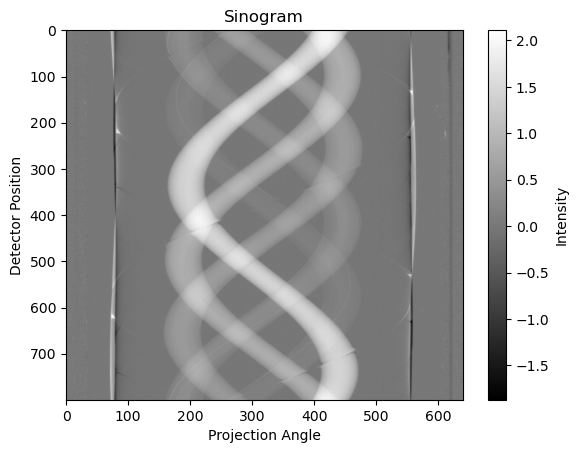

In [3]:
# plt.figure(figsize=(15, 6))
# for i in range(3):
#     plt.subplot(1, 3, i+1)
#     plt.imshow(img_data[:,160+i*10], cmap="gray", aspect="auto")
#     plt.title(f"Sinogram {i+1}")
plt.imshow(data_red[240,:,:], cmap="gray", aspect="auto")
plt.title("Sinogram")
plt.xlabel("Projection Angle")
plt.ylabel("Detector Position")
plt.colorbar(label="Intensity")
plt.show()

(640,)


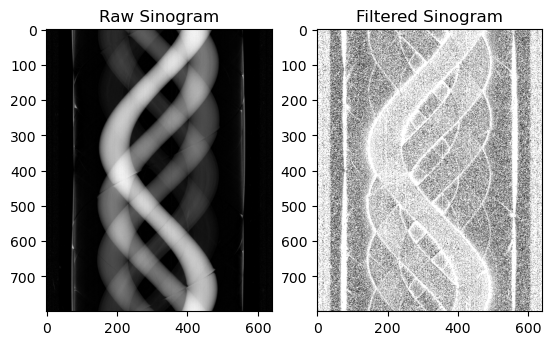

In [4]:
ramp_window = np.ones(640)
print(ramp_window.shape)
ramp_window[:len(ramp_window)//2] = np.linspace(1,0,len(ramp_window)//2)
ramp_window[len(ramp_window)//2:] = np.linspace(0,1,len(ramp_window)-len(ramp_window)//2)
data_fourier = fftshift(fft(ifftshift(data_red,axes=2),axis=2),axes=2)
data_fourier = data_fourier*ramp_window[np.newaxis,np.newaxis,:]
plt.subplot(1,2,1)
plt.imshow(np.abs(data_red)[330],cmap='gray')
plt.title("Raw Sinogram")
# plt.colorbar()
data_red = (fftshift(ifft(ifftshift(data_fourier,axes=2),axis=2),axes=2))
plt.subplot(1,2,2)
plt.imshow(np.abs(data_red)[330],cmap='gray')
plt.clim(0,0.008)
plt.title("Filtered Sinogram")
# plt.colorbar()
plt.show()

In [5]:
HLS = 11.733333333333334
VLS = 8.8
detector_pixel_size = HLS / 640 # VLS / 480
source_origin = 61.723880597014933/detector_pixel_size
origin_det = 4.5/detector_pixel_size

cone_geom_red = astra.create_proj_geom(
    'cone',
    1,
    1,
    480,
    640,
    np.linspace(0, 2*np.pi, 800, endpoint=False),
    source_origin,
    origin_det
)
sinogram_id = astra.data3d.create(datatype='-sino', data=data_red, geometry=cone_geom_red) #TODO
vol_geom = astra.create_vol_geom(640,640,480)
# cfg = astra.astra_dict('BP3D_CUDA')
cfg = astra.astra_dict('BP3D_CUDA')
# cfg = astra.astra_dict('SIRT3D_CUDA')
# cfg = astra.astra_dict('CGLS3D_CUDA')
cfg['ReconstructionDataId'] = astra.data3d.create(datatype='-vol', geometry=vol_geom,data=0)
cfg['ProjectionDataId'] = sinogram_id
alg_id = astra.algorithm.create(cfg)

/home/dengyipin/anaconda3/envs/medical_proj/lib/python3.10/site-packages/astra/data3d.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  return d.create(datatype,geometry,data)


In [6]:
astra.algorithm.run(alg_id, 25)
recon = astra.data3d.get(cfg['ReconstructionDataId'])
sinogram = astra.data3d.get(cfg['ProjectionDataId'])
print(sinogram.shape,recon.shape)

(480, 800, 640) (480, 640, 640)


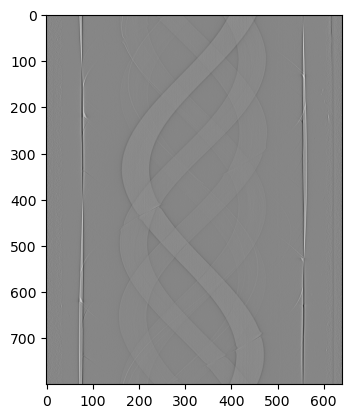

In [7]:
plt.imshow(sinogram[240,:,:],cmap='gray')

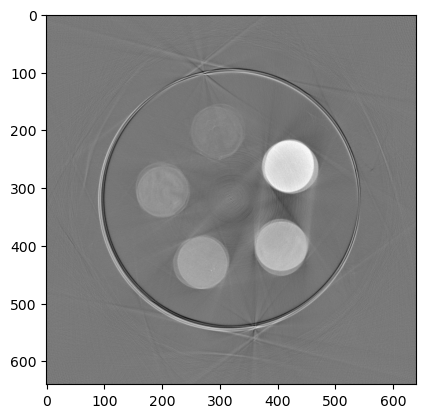

In [10]:
# slice = np.array([100,180,260,340])+15

# plt.figure(figsize=(10,5))
# for i in range(4):
#     plt.subplot(2,4,i+1)
#     plt.imshow(recon[slice[i]],cmap='gray')
# plt.show()

plt.imshow(recon[355],cmap='gray')

In [9]:
astra.algorithm.delete(alg_id)
astra.data3d.delete(sinogram_id)
astra.data3d.delete(cfg['ReconstructionDataId'])